In [1]:
import os
import sys
import re
import json
import numpy as np
import pandas as pd
from collections import defaultdict

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../onmt'))
if module_path not in sys.path:
    sys.path.append(module_path)

import kp_evaluate
import onmt.keyphrase.utils as utils

import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from nltk.stem.porter import PorterStemmer

In [195]:
dataset_names = ['inspec', 'krapivin', 'nus', 'semeval', 'kp20k', 'duc', 'stackexchange']
dataset_names = ['kp20k', 'magkp']

# json_base_dir = '/Users/memray/project/kp/OpenNMT-kpg/data/keyphrase/json/' # path to the json folder
json_base_dir = '/zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/data/keyphrase/json' # path on CRC

tgt_nums = {}
    
for dataset_name in dataset_names:
    tgt_nums[dataset_name] = []
    print(dataset_name)

    input_json_path = os.path.join(json_base_dir, dataset_name, '%s_train.json' % dataset_name)
    
    with open(input_json_path, 'r') as input_json:
        for json_line in input_json:
            json_dict = json.loads(json_line)

            if dataset_name == 'stackexchange':
                json_dict['abstract'] = json_dict['question']
                json_dict['keywords'] = json_dict['tags']            
                del json_dict['question']
                del json_dict['tags']

            title = json_dict['title']
            abstract = json_dict['abstract']
            fulltext = json_dict['fulltext'] if 'fulltext' in json_dict else ''
            keywords = json_dict['keywords']

            if isinstance(keywords, str):
                keywords = keywords.split(';')
                json_dict['keywords'] = keywords
            
            tgt_nums[dataset_name].append(len(keywords))

    print(scipy.stats.describe(tgt_nums[dataset_name]))

kp20k
DescribeResult(nobs=514154, minmax=(1, 110), mean=5.270924664594655, variance=14.141117540879774, skewness=5.39192287405869, kurtosis=40.41415445884668)
magkp
DescribeResult(nobs=2699094, minmax=(1, 438), mean=15.414788814320657, variance=168.752782332351, skewness=1.8635894274050995, kurtosis=7.294107031214651)


### Visualize histogram of two datasets

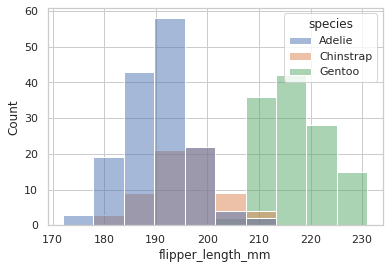

In [12]:
sns.__version__
penguins = sns.load_dataset("penguins")
sns.histplot(data=penguins, x="flipper_length_mm", hue="species")

Text(0.5, 1.0, 'Histogram of #(kp per document) of KP20k and MagKP')

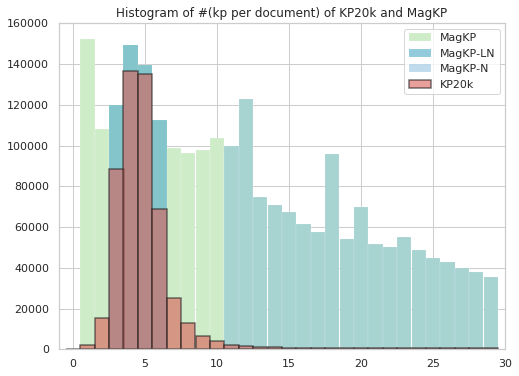

In [20]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))

tmp_tgt_nums = [n for n in tgt_nums["magkp"] if n <= 30]
sns.distplot(tmp_tgt_nums, color=sns.color_palette("Greens_r", 8)[6], label="MagKP", bins=np.arange(31) - 0.5, kde=False, rug=False, hist_kws=dict(alpha=1.0, edgecolor="w", linewidth=0.2))

tmp_tgt_nums = [n for n in tgt_nums["magkp"] if n >= 3 and n <= 6]
sns.distplot(tmp_tgt_nums, label="MagKP-LN", bins=np.arange(31)-0.5, 
             color="c",
             kde=False, rug=False, hist_kws=dict(alpha=0.7, edgecolor="w", linewidth=0.1))

tmp_tgt_nums = [n for n in tgt_nums["magkp"] if n > 10 and n <= 30]
sns.distplot(tmp_tgt_nums, color=sns.color_palette("Blues_r", 8)[4], label="MagKP-N", bins=np.arange(31)-0.5, kde=False, rug=False, hist_kws=dict(alpha=0.5, edgecolor="w", linewidth=0.2))

tmp_tgt_nums = [n for n in tgt_nums["kp20k"] if n <= 30]
sns.distplot(tmp_tgt_nums, color=sns.color_palette("hls", 8)[0], label="KP20k", bins=np.arange(31) - 0.5, kde=False, rug=False, hist_kws=dict(alpha=0.6, edgecolor="k", linewidth=1.5))

plt.xlim([-1, 30])
plt.legend(loc='upper right')
ax.set_title('Histogram of #(kp per document) of KP20k and MagKP')

2391870
521542
1520307
521542
511653


Text(0.5, 0, '#(phrase) per paper')

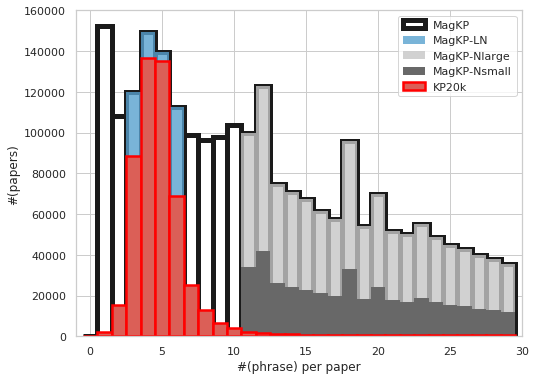

In [203]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))

tmp_tgt_nums = [n for n in tgt_nums["magkp"] if n <= 30]
print(len(tmp_tgt_nums))
sns.distplot(tmp_tgt_nums, label="MagKP",
             bins=np.arange(31) - 0.5, color="w",
             hist_kws=dict(alpha=1.0, edgecolor="k", linewidth=5.0),
             kde=False, kde_kws={"color": "k", "lw": 3, "label": "KDE"})

tmp_tgt_nums = [n for n in tgt_nums["magkp"] if n >= 3 and n <= 6]
magkpln_tgt_nums = tmp_tgt_nums
print(len(tmp_tgt_nums))
sns.distplot(tmp_tgt_nums, label="MagKP-LN", 
             bins=np.arange(31)-0.5, color=sns.color_palette("Blues_r", 8)[3],
             kde=False, rug=False, hist_kws=dict(alpha=0.8, edgecolor="k", linewidth=0.0))

tmp_tgt_nums = [n for n in tgt_nums["magkp"] if n > 10]
print(len(tmp_tgt_nums))
sns.distplot(tmp_tgt_nums, label="MagKP-Nlarge", 
             bins=np.arange(31)-0.5, color=sns.color_palette("Greys_r", 8)[5],
             kde=False, rug=False, hist_kws=dict(alpha=0.8, edgecolor="k", linewidth=0.0))


tmp_tgt_nums = [n for n in tgt_nums["magkp"] if n > 10]
tmp_tgt_nums = tmp_tgt_nums[: len(magkpln_tgt_nums)]
print(len(tmp_tgt_nums))
sns.distplot(tmp_tgt_nums, label="MagKP-Nsmall", 
             bins=np.arange(31)-0.5, color=sns.color_palette("Greys_r", 8)[2],
             kde=False, rug=False, hist_kws=dict(alpha=1.0, edgecolor="k", linewidth=0.0))

tmp_tgt_nums = [n for n in tgt_nums["kp20k"] if n <= 30]
print(len(tmp_tgt_nums))
sns.distplot(tmp_tgt_nums, label="KP20k", 
             bins=np.arange(31) - 0.5, color=sns.color_palette("hls", 8)[0], 
             kde=False, rug=False, hist_kws=dict(alpha=1.0, edgecolor="red", linewidth=2.5))

plt.xlim([-1, 30])
plt.legend(loc='upper right')
ax.set_ylabel('#(papers)')
ax.set_xlabel('#(phrase) per paper')
# ax.set_title('Histogram of #(kp per document) of KP20k and MagKP')

#### Check #(unique_kp) in each dataset

In [ ]:
dataset_names = ['kp20k', 'magkp']

# json_base_dir = '/Users/memray/project/kp/OpenNMT-kpg/data/keyphrase/json/' # path to the json folder
json_base_dir = '/zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/data/keyphrase/json' # path on CRC

dataset_tgt_dict = {}
    
for dataset_name in dataset_names:
    dataset_tgt_dict[dataset_name] = []
    print(dataset_name)

    input_json_path = os.path.join(json_base_dir, dataset_name, '%s_train.json' % dataset_name)
    
    with open(input_json_path, 'r') as input_json:
        for json_line in input_json:
            json_dict = json.loads(json_line)

            if dataset_name == 'stackexchange':
                json_dict['abstract'] = json_dict['question']
                json_dict['keywords'] = json_dict['tags']            
                del json_dict['question']
                del json_dict['tags']

            title = json_dict['title']
            abstract = json_dict['abstract']
            fulltext = json_dict['fulltext'] if 'fulltext' in json_dict else ''
            keywords = json_dict['keywords']

            if isinstance(keywords, str):
                keywords = keywords.split(';')
                json_dict['keywords'] = keywords
            keywords = [k.lower().strip() for k in keywords]
            
            dataset_tgt_dict[dataset_name].append(keywords)


In [186]:
# prepare Magkp subsets
dataset_tgt_dict['magkp_ln'] = [kps for kps in dataset_tgt_dict["magkp"] if len(kps) >= 3 and len(kps) <= 6]
dataset_tgt_dict['magkp_nlarge'] = [kps for kps in dataset_tgt_dict["magkp"] if len(kps) > 10]
dataset_tgt_dict['magkp_nsmall'] = dataset_tgt_dict['magkp_nlarge'][: len(dataset_tgt_dict['magkp_ln'])]


In [206]:

for dataset, kps_list in dataset_tgt_dict.items():
    kp_set = set()
    num_kp = 0
    max_kp_in_doc = 0
    max_len_kp = 0
    len_kp_list = []
    for kps in kps_list:
        for kp in kps:
            kp_set.add(kp)
            num_kp += 1
            num_word = len(kp.split())
            len_kp_list.append(num_word)
            if num_word > max_len_kp:
                max_len_kp = num_word
        if len(kps) > max_kp_in_doc:
            max_kp_in_doc = len(kps)
    num_unique_kp = len(kp_set)
    print('*' * 50)
    print(dataset)
    print('num_doc=', len(kps_list))
    print('num_unique_kp=', num_unique_kp)
    print('num_kp=', num_kp)
    print('len_kp=', np.mean(len_kp_list))
    print('max_kp_in_doc=', max_kp_in_doc)
    print('len_kp_list=', max_len_kp)
    

**************************************************
kp20k
num_doc= 514154
num_unique_kp= 699791
num_kp= 2710067
len_kp= 1.9230266262789812
max_kp_in_doc= 110
len_kp_list= 91
**************************************************
magkp
num_doc= 2699094
num_unique_kp= 6880853
num_kp= 41605964
len_kp= 3.4161944427005704
max_kp_in_doc= 438
len_kp_list= 100
**************************************************
magkp_ln
num_doc= 521542
num_unique_kp= 579244
num_kp= 2331072
len_kp= 2.726639932185707
max_kp_in_doc= 6
len_kp_list= 100
**************************************************
magkp_nlarge
num_doc= 1520307
num_unique_kp= 5784959
num_kp= 35525765
len_kp= 3.376301903702848
max_kp_in_doc= 438
len_kp_list= 100
**************************************************
magkp_nsmall
num_doc= 521542
num_unique_kp= 2236091
num_kp= 12193980
len_kp= 3.3652286620119107
max_kp_in_doc= 262
len_kp_list= 100


#### print num_paper binned by num_kp

In [5]:
tmp_tgt_nums = [n for n in tgt_nums["kp20k"] if n <= 30]
for bin_count in np.bincount(tmp_tgt_nums):
    print(bin_count)

0
1884
15433
88651
136732
135117
68930
25108
12786
6306
3871
2054
1517
1088
945
859
817
844
793
866
856
807
731
743
676
657
604
546
500
492
440


#### Hatch-filled histograms

In [77]:
import itertools
from collections import OrderedDict
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cycler import cycler
from six.moves import zip


def filled_hist(ax, edges, values, bottoms=None, orientation='v',
                **kwargs):
    """
    Draw a histogram as a stepped patch.

    Extra kwargs are passed through to `fill_between`

    Parameters
    ----------
    ax : Axes
        The axes to plot to

    edges : array
        A length n+1 array giving the left edges of each bin and the
        right edge of the last bin.

    values : array
        A length n array of bin counts or values

    bottoms : scalar or array, optional
        A length n array of the bottom of the bars.  If None, zero is used.

    orientation : {'v', 'h'}
       Orientation of the histogram.  'v' (default) has
       the bars increasing in the positive y-direction.

    Returns
    -------
    ret : PolyCollection
        Artist added to the Axes
    """
    print(orientation)
    if orientation not in set('hv'):
        raise ValueError("orientation must be in {{'h', 'v'}} "
                         "not {o}".format(o=orientation))

    kwargs.setdefault('step', 'post')
    edges = np.asarray(edges)
    values = np.asarray(values)
    if len(edges) - 1 != len(values):
        raise ValueError('Must provide one more bin edge than value not: '
                         'len(edges): {lb} len(values): {lv}'.format(
                             lb=len(edges), lv=len(values)))

    if bottoms is None:
        bottoms = np.zeros_like(values)
    if np.isscalar(bottoms):
        bottoms = np.ones_like(values) * bottoms

    values = np.r_[values, values[-1]]
    bottoms = np.r_[bottoms, bottoms[-1]]
    if orientation == 'h':
        return ax.fill_betweenx(edges, values, bottoms,
                                **kwargs)
    elif orientation == 'v':
        return ax.fill_between(edges, values, bottoms,
                               **kwargs)
    else:
        raise AssertionError("you should never be here")


def stack_hist(ax, stacked_data, sty_cycle, bottoms=None,
               hist_func=None, labels=None,
               plot_func=None, plot_kwargs=None):
    """
    ax : axes.Axes
        The axes to add artists too

    stacked_data : array or Mapping
        A (N, M) shaped array.  The first dimension will be iterated over to
        compute histograms row-wise

    sty_cycle : Cycler or operable of dict
        Style to apply to each set

    bottoms : array, optional
        The initial positions of the bottoms, defaults to 0

    hist_func : callable, optional
        Must have signature `bin_vals, bin_edges = f(data)`.
        `bin_edges` expected to be one longer than `bin_vals`

    labels : list of str, optional
        The label for each set.

        If not given and stacked data is an array defaults to 'default set {n}'

        If stacked_data is a mapping, and labels is None, default to the keys
        (which may come out in a random order).

        If stacked_data is a mapping and labels is given then only
        the columns listed by be plotted.

    plot_func : callable, optional
        Function to call to draw the histogram must have signature:

          ret = plot_func(ax, edges, top, bottoms=bottoms,
                          label=label, **kwargs)

    plot_kwargs : dict, optional
        Any extra kwargs to pass through to the plotting function.  This
        will be the same for all calls to the plotting function and will
        over-ride the values in cycle.

    Returns
    -------
    arts : dict
        Dictionary of artists keyed on their labels
    """
    # deal with default binning function
    if hist_func is None:
        hist_func = np.histogram

    # deal with default plotting function
    if plot_func is None:
        plot_func = filled_hist

    # deal with default
    if plot_kwargs is None:
        plot_kwargs = {}
    print(plot_kwargs)
    try:
        l_keys = stacked_data.keys()
        label_data = True
        if labels is None:
            labels = l_keys

    except AttributeError:
        label_data = False
        if labels is None:
            labels = itertools.repeat(None)

    if label_data:
        loop_iter = enumerate((stacked_data[lab], lab, s) for lab, s in
                              zip(labels, sty_cycle))
    else:
        loop_iter = enumerate(zip(stacked_data, labels, sty_cycle))

    arts = {}
    for j, (data, label, sty) in loop_iter:
        if label is None:
            label = 'dflt set {n}'.format(n=j)
        label = sty.pop('label', label)
        vals, edges = hist_func(data)
        if bottoms is None:
            bottoms = np.zeros_like(vals)
        top = bottoms + vals # stack
        top = vals # non-stack
        print(label)
        print(sty)
        sty.update(plot_kwargs)
        print(sty)
        ret = plot_func(ax, edges, top, bottoms=bottoms,
                        label=label, **sty)
        bottoms = top
        arts[label] = ret
    ax.legend(fontsize=10)
    return arts


In [103]:
kp_data = OrderedDict()

kp_data["MagKP"] = [n for n in tgt_nums["magkp"] if n <= 10 and (n < 3 or n > 6)]
kp_data["MagKP-Nlarge"] = [n for n in tgt_nums["magkp"] if n > 10 and n <= 30]
kp_data["MagKP-Nsmall"] = [n for n in tgt_nums["magkp"] if n > 10 and n <= 30]
kp_data["MagKP-Nsmall"] = kp_data["MagKP-Nsmall"][: len(kp_data["MagKP-Nsmall"]) // 2]
kp_data["MagKP-LN"] = [n for n in tgt_nums["magkp"] if n >= 3 and n <= 6]
kp_data["KP20k"] = [n for n in tgt_nums["kp20k"] if n <= 30]


odict_keys(['MagKP', 'MagKP-Nlarge', 'MagKP-Nsmall', 'MagKP-LN', 'KP20k'])
{}
MagKP
{'facecolor': (0.33999999999999997, 0.8287999999999999, 0.86), 'hatch': ' ', 'alpha': 0.6}
{'facecolor': (0.33999999999999997, 0.8287999999999999, 0.86), 'hatch': ' ', 'alpha': 0.6}
v
MagKP-Nlarge
{'facecolor': (0.33999999999999997, 0.8287999999999999, 0.86), 'hatch': '/', 'alpha': 0.6}
{'facecolor': (0.33999999999999997, 0.8287999999999999, 0.86), 'hatch': '/', 'alpha': 0.6}
v
MagKP-Nsmall
{'facecolor': (0.33999999999999997, 0.8287999999999999, 0.86), 'hatch': 'o', 'alpha': 0.5}
{'facecolor': (0.33999999999999997, 0.8287999999999999, 0.86), 'hatch': 'o', 'alpha': 0.5}
v
MagKP-LN
{'facecolor': (0.33999999999999997, 0.8287999999999999, 0.86), 'hatch': '+', 'alpha': 0.5}
{'facecolor': (0.33999999999999997, 0.8287999999999999, 0.86), 'hatch': '+', 'alpha': 0.5}
v
KP20k
{'facecolor': (0.86, 0.3712, 0.33999999999999997), 'hatch': ' ', 'alpha': 1.0}
{'facecolor': (0.86, 0.3712, 0.33999999999999997), 'hatch': 

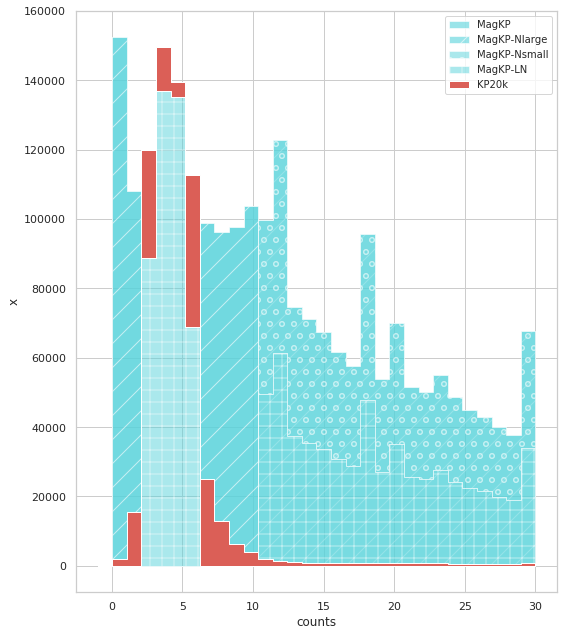

In [107]:
# set up histogram function to fixed bins
edges = np.linspace(-1, 30, 31, endpoint=True)
hist_func = partial(np.histogram, bins=edges)

print(kp_data.keys())
# set up style cycles
color_cycle = cycler(facecolor=[sns.color_palette("hls", 8)[4],
                                sns.color_palette("hls", 8)[4],
                                sns.color_palette("hls", 8)[4],
                                sns.color_palette("hls", 8)[4],
                                sns.color_palette("hls", 8)[0],
                               ])
hatch_cycle = cycler(hatch=[' ', '/', 'o', '+', ' '])
# hatch_cycle = cycler(hatch=[' ', '/', 'o', '+', '|'])
alpha_cycle = cycler(alpha=[0.6, 0.6, 0.5, 0.5, 1.0])
# hist_kws=dict(alpha=0.5, edgecolor="w", linewidth=0.2)

# Fixing random state for reproducibility
np.random.seed(19680801)


fig, ax = plt.subplots(figsize=(8, 9), tight_layout=True, sharey=True)

arts = stack_hist(ax, kp_data,
                  sty_cycle=color_cycle + hatch_cycle + alpha_cycle,
                  labels=kp_data.keys(), hist_func=hist_func)

ax.set_xlabel('counts')
ax.set_ylabel('x')

plt.show()

### Stats of KP20k

##### w/o preprocessing

All documents
- #(data examples)=514,154 
- #(KP)=2,710,067
- #(unique KP)=710,218
 
 
For documents whose \#(kp)>10
- #(DP)=19,336 (3.76%)
- #(KP)=401,763 (14.82%)
- #(unique KP)=52,176 (7.35%)


##### w/ preprocessing
All documents
- #(DP)=514,154
- #(KP)=2,710,067
- #(unique KP)=625,058 (diff between w/&w/o preprocessing: 85,160)

For documents whose \#(kp)>10
- #(DP)=19,336
- #(KP)=401,763 (14.82%)
- #(unique KP)=48,125 (7.70%, diff between w/&w/o preprocessing: 4,051)

#### Count #kp per document

In [20]:
data = tgt_nums["kp20k"]
print(scipy.stats.describe(data))

for p in np.linspace(0, 100, 101):
    percentile = np.percentile(data, p, interpolation='lower')
    print('Percentile@%.0f = %.6f' % (p, percentile))

DescribeResult(nobs=514154, minmax=(1, 110), mean=5.270924664594655, variance=14.141117540879774, skewness=5.39192287405869, kurtosis=40.41415445884668)
Percentile@0 = 1.000000
Percentile@1 = 2.000000
Percentile@2 = 2.000000
Percentile@3 = 2.000000
Percentile@4 = 3.000000
Percentile@5 = 3.000000
Percentile@6 = 3.000000
Percentile@7 = 3.000000
Percentile@8 = 3.000000
Percentile@9 = 3.000000
Percentile@10 = 3.000000
Percentile@11 = 3.000000
Percentile@12 = 3.000000
Percentile@13 = 3.000000
Percentile@14 = 3.000000
Percentile@15 = 3.000000
Percentile@16 = 3.000000
Percentile@17 = 3.000000
Percentile@18 = 3.000000
Percentile@19 = 3.000000
Percentile@20 = 3.000000
Percentile@21 = 4.000000
Percentile@22 = 4.000000
Percentile@23 = 4.000000
Percentile@24 = 4.000000
Percentile@25 = 4.000000
Percentile@26 = 4.000000
Percentile@27 = 4.000000
Percentile@28 = 4.000000
Percentile@29 = 4.000000
Percentile@30 = 4.000000
Percentile@31 = 4.000000
Percentile@32 = 4.000000
Percentile@33 = 4.000000
Percent

In [27]:
tmp_tgt_nums = [n for n in tgt_nums["kp20k"] if n >=3 and n <= 6]
print('%d/%d' % (len(tmp_tgt_nums), len(tgt_nums["kp20k"])))

429430/514154


Text(0.5, 1.0, 'Histogram of #(kp per document) of KP20k (truncated at 10)')

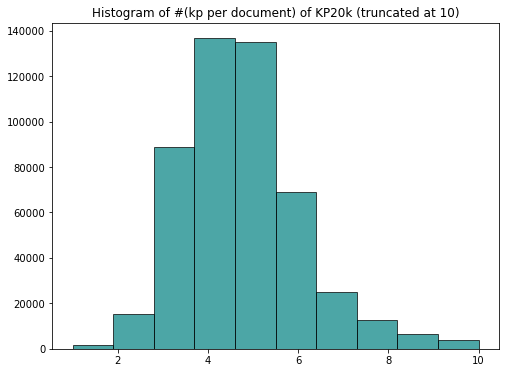

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

tmp_tgt_nums = [n for n in tgt_nums["kp20k"] if n <= 10]
sns.distplot(tmp_tgt_nums, color="teal", label="KP20k", bins=10, kde=False, rug=False, hist_kws=dict(alpha=0.7, edgecolor="k", linewidth=1))

ax.set_title('Histogram of #(kp per document) of KP20k (truncated at 10)')

Text(0.5, 1.0, 'Histogram of #(kp per document) of KP20k')

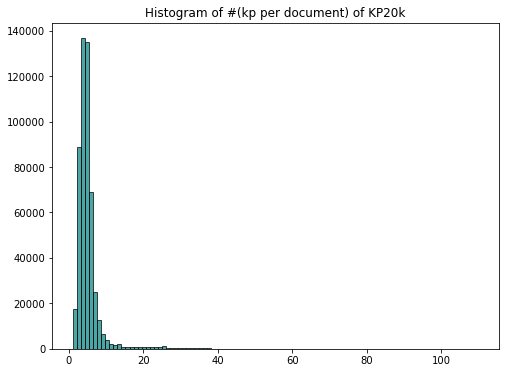

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

tmp_tgt_nums = [n for n in tgt_nums["kp20k"]]
sns.distplot(tmp_tgt_nums, color="teal", label="KP20k", bins=100, kde=False, rug=False, hist_kws=dict(alpha=0.7, edgecolor="k", linewidth=1))

ax.set_title('Histogram of #(kp per document) of KP20k')

#### Count unique phrases

##### only count documents that #(kp)>10

In [30]:
dataset_name = 'kp20k'
do_preprocess = True

stemmer = PorterStemmer()
json_base_dir = '/zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/data/keyphrase/json' # path on CRC
input_json_path = os.path.join(json_base_dir, dataset_name, '%s_train.json' % dataset_name)

unique_kp_counter = defaultdict(lambda: 0)
num_data = 0
num_kp = 0

with open(input_json_path, 'r') as input_json:
    for json_line in input_json:
        json_dict = json.loads(json_line)

        if dataset_name == 'stackexchange':
            json_dict['abstract'] = json_dict['question']
            json_dict['keywords'] = json_dict['tags']            
            del json_dict['question']
            del json_dict['tags']

        title = json_dict['title']
        abstract = json_dict['abstract']
        fulltext = json_dict['fulltext'] if 'fulltext' in json_dict else ''
        keywords = json_dict['keywords']

        if isinstance(keywords, str):
            keywords = keywords.split(';')
            json_dict['keywords'] = keywords
        
        if len(keywords) > 10:
            num_data += 1
            for keyword in keywords:
                num_kp += 1
                if do_preprocess:
                    tokens = [stemmer.stem(t) for t in keyword.lower().split()]
                    keyword = '_'.join(tokens)
                    
                unique_kp_counter[keyword] = unique_kp_counter[keyword] + 1

print('#(DP)=%d' % num_data)
print('#(KP)=%d' % num_kp)
print('#(unique KP)=%d' % len(unique_kp_counter))

#(DP)=19336
#(KP)=401763
#(unique KP)=48125


#####  count all documents #(kp)>0

In [13]:
dataset_name = 'kp20k'
do_preprocess = False

stemmer = PorterStemmer()
json_base_dir = '/zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/data/keyphrase/json' # path on CRC
input_json_path = os.path.join(json_base_dir, dataset_name, '%s_train.json' % dataset_name)

unique_kp_counter = defaultdict(lambda: 0)
kp_len_counter = defaultdict(lambda: 0)
num_data = 0
num_kp = 0

with open(input_json_path, 'r') as input_json:
    for json_line in input_json:
        json_dict = json.loads(json_line)

        if dataset_name == 'stackexchange':
            json_dict['abstract'] = json_dict['question']
            json_dict['keywords'] = json_dict['tags']            
            del json_dict['question']
            del json_dict['tags']

        title = json_dict['title']
        abstract = json_dict['abstract']
        fulltext = json_dict['fulltext'] if 'fulltext' in json_dict else ''
        keywords = json_dict['keywords']

        if isinstance(keywords, str):
            keywords = keywords.split(';')
            json_dict['keywords'] = keywords
        
        if len(keywords) > 0:
            num_data += 1
            for keyword in keywords:
                num_kp += 1
                if do_preprocess:
                    tokens = [stemmer.stem(t) for t in keyword.lower().split()]
                    keyword = ' '.join(tokens)
                    
                tokens = [t for t in keyword.split()]
                kp_len_counter[len(tokens)] = kp_len_counter[len(tokens)] + 1
                unique_kp_counter[keyword] = unique_kp_counter[keyword] + 1

print('#(DP)=%d' % num_data)
print('#(KP)=%d' % num_kp)
print('#(unique KP)=%d' % len(unique_kp_counter))

#(DP)=514154
#(KP)=2710067
#(unique KP)=710218


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-122aac1b16ff>", line 3, in <module>
    tmp_kp_freqs = [v for k,v in unique_kp_counter.items() if v > 1000]
NameError: name 'unique_kp_counter' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow.py", line 58, in <m

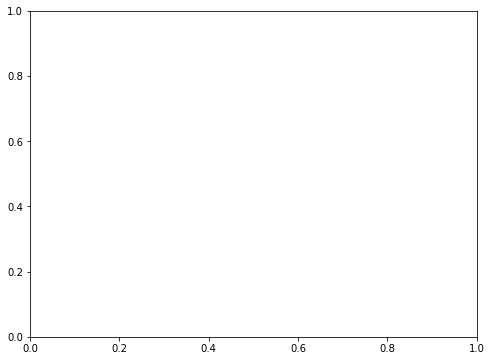

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

tmp_kp_freqs = [v for k,v in unique_kp_counter.items() if v > 1000]
sns.distplot(tmp_kp_freqs, color="teal", label="KP20k", bins=15, kde=False, rug=False, hist_kws=dict(alpha=0.7, edgecolor="k", linewidth=1))


####  KP length distribution

#kp_len=0, freq=63, accum/total=0.00%
#kp_len=1, freq=907946, accum/total=33.51%
#kp_len=2, freq=1267094, accum/total=80.26%
#kp_len=3, freq=418621, accum/total=95.71%
#kp_len=4, freq=87761, accum/total=98.95%
#kp_len=5, freq=19873, accum/total=99.68%
#kp_len=6, freq=5200, accum/total=99.87%
#kp_len=7, freq=1625, accum/total=99.93%
#kp_len=8, freq=670, accum/total=99.96%
#kp_len=9, freq=268, accum/total=99.97%
#kp_len=10, freq=147, accum/total=99.97%
#kp_len=11, freq=219, accum/total=99.98%
#kp_len=12, freq=234, accum/total=99.99%
#kp_len=13, freq=98, accum/total=99.99%
#kp_len=14, freq=38, accum/total=99.99%
#kp_len=15, freq=41, accum/total=99.99%
#kp_len=16, freq=30, accum/total=99.99%
#kp_len=17, freq=19, accum/total=100.00%
#kp_len=18, freq=9, accum/total=100.00%
#kp_len=19, freq=21, accum/total=100.00%
#kp_len=20, freq=14, accum/total=100.00%
#kp_len=21, freq=12, accum/total=100.00%
#kp_len=22, freq=5, accum/total=100.00%
#kp_len=23, freq=17, accum/total=100.00%
#kp_len=24, freq=1

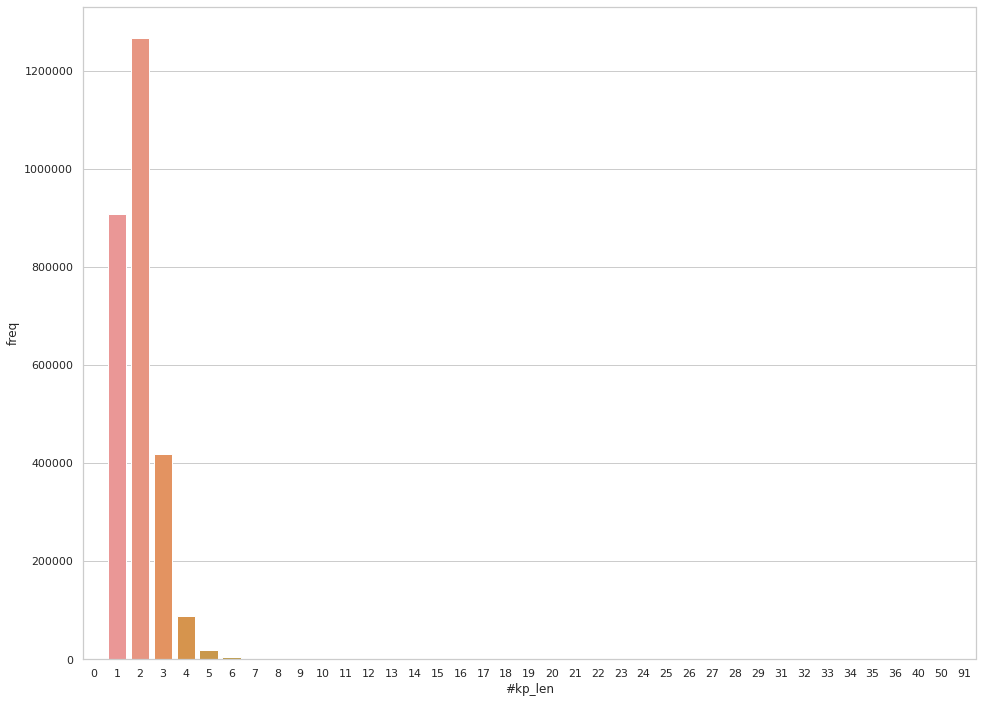

In [16]:
fig, ax = plt.subplots(figsize=(16, 12))
sns.set(style="whitegrid")
kp_lens = sorted([(kp_len, freq) for kp_len, freq in kp_len_counter.items()], key=lambda k:k[0])

accum_kp_count = 0
total_kp_count = sum(freq for _, freq in kp_lens)
for kp_len, freq in kp_lens:
    accum_kp_count += freq
    print('#kp_len=%d, freq=%d, accum/total=%.2f%%' % (kp_len, freq, accum_kp_count / total_kp_count * 100))
    
print(len(kp_lens))
kp_lens_df = pd.DataFrame(kp_lens, columns=['#kp_len', 'freq'])
ax = sns.barplot(x="#kp_len", y="freq", data=kp_lens_df)


### Stats of MagKP

##### w/o preprocessing

All documents
- #(DP)=2,699,094
- #(KP)=41,605,964
- #(unique KP)=6,880,853

For documents whose \#(kp)>10
- #(DP)=1,520,307 (56.33%)
- #(KP)=35,525,765 (85.39%)
- #(unique KP)=5,784,959 (84.07%)

##### w/ preprocessing (lowercase and stemming)

All documents
- #(DP)=2,699,094
- #(KP)=41,605,964
- #(unique KP)=6,537,481 (diff between w/&w/o preprocessing: 343,372, 5.25% difference)

For documents whose \#(kp)>10
- #(DP)=1,520,307
- #(KP)=35,525,765 （85.39%）
- #(unique KP)=5,493,997 (84.04%, diff between w/&w/o preprocessing: 290,962)

#### Count #kp per document

In [3]:
data = tgt_nums["magkp"]
print(scipy.stats.describe(data))

data = tgt_nums["magkp"]
for p in np.linspace(0, 100, 101):
    percentile = np.percentile(data, p, interpolation='lower')
    print('Percentile@%.0f = %.6f' % (p, percentile))

DescribeResult(nobs=2699094, minmax=(1, 438), mean=15.414788814320657, variance=168.752782332351, skewness=1.8635894274050995, kurtosis=7.294107031214651)
Percentile@0 = 1.000000
Percentile@1 = 1.000000
Percentile@2 = 1.000000
Percentile@3 = 1.000000
Percentile@4 = 1.000000
Percentile@5 = 1.000000
Percentile@6 = 2.000000
Percentile@7 = 2.000000
Percentile@8 = 2.000000
Percentile@9 = 2.000000
Percentile@10 = 3.000000
Percentile@11 = 3.000000
Percentile@12 = 3.000000
Percentile@13 = 3.000000
Percentile@14 = 3.000000
Percentile@15 = 4.000000
Percentile@16 = 4.000000
Percentile@17 = 4.000000
Percentile@18 = 4.000000
Percentile@19 = 4.000000
Percentile@20 = 5.000000
Percentile@21 = 5.000000
Percentile@22 = 5.000000
Percentile@23 = 5.000000
Percentile@24 = 5.000000
Percentile@25 = 6.000000
Percentile@26 = 6.000000
Percentile@27 = 6.000000
Percentile@28 = 6.000000
Percentile@29 = 7.000000
Percentile@30 = 7.000000
Percentile@31 = 7.000000
Percentile@32 = 7.000000
Percentile@33 = 8.000000
Perce

#### Histogram of #(kp per document) < 61

Text(0.5, 1.0, 'Histogram of #(kp per document) of MagKP (truncated at 60)')

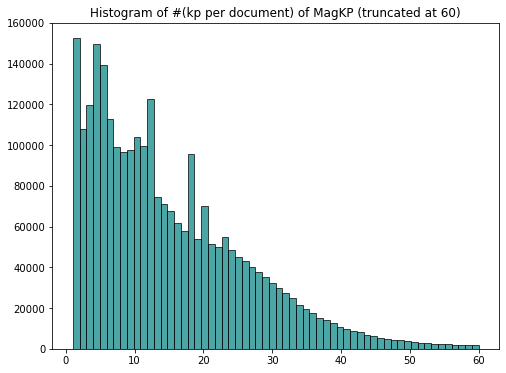

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

tmp_tgt_nums = [n for n in tgt_nums["magkp"] if n < 61]
sns.distplot(tmp_tgt_nums, color="teal", label="MagKP", bins=60, kde=False, rug=False, hist_kws=dict(alpha=0.7, edgecolor="k", linewidth=1))

ax.set_title('Histogram of #(kp per document) of MagKP (truncated at 60)')

#### Histogram of #(kp per document) < 11

Text(0.5, 1.0, 'Histogram of #(kp per document) of MagKP (truncated at 10)')

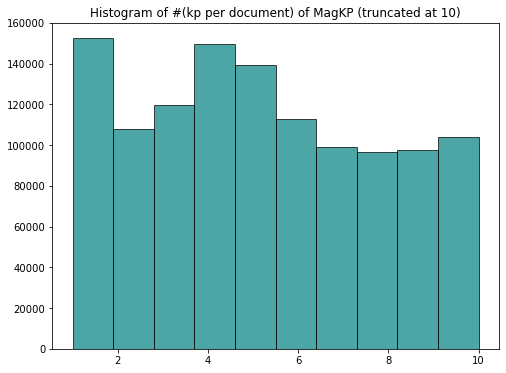

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))

tmp_tgt_nums = [n for n in tgt_nums["magkp"] if n <= 10]
sns.distplot(tmp_tgt_nums, color="teal", label="MagKP", bins=10, kde=False, rug=False, hist_kws=dict(alpha=0.7, edgecolor="k", linewidth=1))

ax.set_title('Histogram of #(kp per document) of MagKP (truncated at 10)')

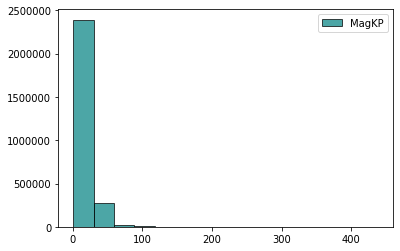

In [24]:
#     sns.distplot(np.asarray(tgt_nums, dtype=int), bins=15, color="r", kde=False, rug=False);
    
    # Plot a simple histogram with binsize determined automatically
#     sns.distplot(tgt_nums, kde=False, color="b", ax=ax)

#     # Plot a kernel density estimate and rug plot
#     sns.distplot(tgt_nums, hist=False, rug=True, color="r")

#     # Plot a filled kernel density estimate
#     sns.distplot(tgt_nums, hist=False, color="g", kde_kws={"shade": True})

#     # Plot a histogram and kernel density estimate
#     sns.distplot(tgt_nums, hist=True, color="m", ax=ax)
    
# sns.distplot(tgt_nums["kp20k"] , color="skyblue", label="KP20k", bins=15, kde=False, rug=False, hist_kws=dict(alpha=0.7))
# sns.distplot(tgt_nums["kp20k"] , color="teal", label="KP20k", bins=15, kde=False, rug=False, hist_kws=dict(alpha=0.7, edgecolor="k", linewidth=1))
sns.distplot(tgt_nums["magkp"] , color="teal", label="MagKP", bins=15, kde=False, rug=False, hist_kws=dict(alpha=0.7, edgecolor="k", linewidth=1))
# sns.distplot(tgt_nums["inspec"] , color="red", label="Inspec", bins=15, kde=False, rug=False, hist_kws=dict(alpha=0.7))
# sns.distplot(tgt_nums["krapivin"] , color="olive", label="Krapivin", bins=15, kde=False, rug=False, hist_kws=dict(alpha=0.7))
# sns.distplot(tgt_nums["nus"] , color="gold", label="NUS", bins=15, kde=False, rug=False, hist_kws=dict(alpha=0.7))
# sns.distplot(tgt_nums["semeval"] , color="teal", label="Semeval", bins=15, kde=False, rug=False, hist_kws=dict(alpha=0.7))

ax.set(xlabel='Number of keyphrases in doc', ylabel='Number of documents')
plt.legend()
plt.show()


#### Count unique phrases

##### only count documents that #(kp)>10

In [29]:
dataset_name = 'magkp'
do_preprocess = True

stemmer = PorterStemmer()

json_base_dir = '/zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/data/keyphrase/json' # path on CRC
input_json_path = os.path.join(json_base_dir, dataset_name, '%s_train.json' % dataset_name)

unique_kp_counter = defaultdict(lambda: 0)
num_data = 0
num_kp = 0

with open(input_json_path, 'r') as input_json:
    for json_line in input_json:
        json_dict = json.loads(json_line)

        if dataset_name == 'stackexchange':
            json_dict['abstract'] = json_dict['question']
            json_dict['keywords'] = json_dict['tags']            
            del json_dict['question']
            del json_dict['tags']

        title = json_dict['title']
        abstract = json_dict['abstract']
        fulltext = json_dict['fulltext'] if 'fulltext' in json_dict else ''
        keywords = json_dict['keywords']

        if isinstance(keywords, str):
            keywords = keywords.split(';')
            json_dict['keywords'] = keywords
            
        if len(keywords) > 10:
            num_data += 1
            for keyword in keywords:
                num_kp += 1
                if do_preprocess:
                    tokens = [stemmer.stem(t) for t in keyword.lower().split()]
                    keyword = '_'.join(tokens)
                    
                unique_kp_counter[keyword] = unique_kp_counter[keyword] + 1

print('#(DP)=%d' % num_data)
print('#(KP)=%d' % num_kp)
print('#(unique KP)=%d' % len(unique_kp_counter))

#(DP)=1520307
#(KP)=35525765
#(unique KP)=5493997


#####  count all documents #(kp)>0

In [17]:
dataset_name = 'magkp'
do_preprocess = False

stemmer = PorterStemmer()

json_base_dir = '/zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/data/keyphrase/json' # path on CRC
input_json_path = os.path.join(json_base_dir, dataset_name, '%s_train.json' % dataset_name)

unique_kp_counter = defaultdict(lambda: 0)
kp_len_counter = defaultdict(lambda: 0)
num_data = 0
num_kp = 0

with open(input_json_path, 'r') as input_json:
    for json_line in input_json:
        json_dict = json.loads(json_line)

        if dataset_name == 'stackexchange':
            json_dict['abstract'] = json_dict['question']
            json_dict['keywords'] = json_dict['tags']            
            del json_dict['question']
            del json_dict['tags']

        title = json_dict['title']
        abstract = json_dict['abstract']
        fulltext = json_dict['fulltext'] if 'fulltext' in json_dict else ''
        keywords = json_dict['keywords']

        if isinstance(keywords, str):
            keywords = keywords.split(';')
            json_dict['keywords'] = keywords
            
        if len(keywords) > 0:
            num_data += 1
            for keyword in keywords:
                num_kp += 1
                if do_preprocess:
                    tokens = [stemmer.stem(t) for t in keyword.lower().split()]
                    keyword = ' '.join(tokens)
#                 print(keyword)
                
                tokens = [t for t in keyword.split()]
                kp_len_counter[len(tokens)] = kp_len_counter[len(tokens)] + 1
                unique_kp_counter[keyword] = unique_kp_counter[keyword] + 1

print('#(DP)=%d' % num_data)
print('#(KP)=%d' % num_kp)
print('#(unique KP)=%d' % len(unique_kp_counter))

#(DP)=2699094
#(KP)=41605964
#(unique KP)=6880853


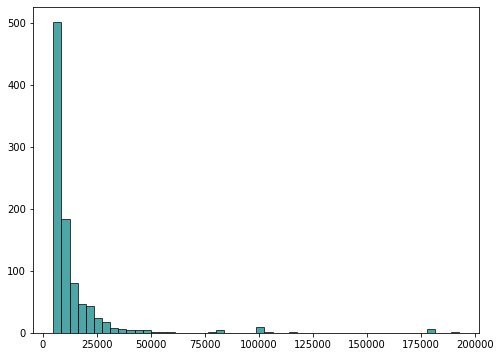

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))

tmp_kp_freqs = [v for k,v in unique_kp_counter.items() if v > 5000]
sns.distplot(tmp_kp_freqs, color="teal", 
             title="Frequency of unique phrases", label="MagKP",
             bins=50, kde=False, rug=False, hist_kws=dict(alpha=0.7, edgecolor="k", linewidth=1))


####  KP length distribution

#kp_len=1, freq=7813072, accum/total=18.78%
#kp_len=2, freq=21476033, accum/total=70.40%
#kp_len=3, freq=6337508, accum/total=85.63%
#kp_len=4, freq=1705544, accum/total=89.73%
#kp_len=5, freq=502647, accum/total=90.94%
#kp_len=6, freq=281022, accum/total=91.61%
#kp_len=7, freq=217690, accum/total=92.13%
#kp_len=8, freq=230406, accum/total=92.69%
#kp_len=9, freq=226450, accum/total=93.23%
#kp_len=10, freq=226740, accum/total=93.78%
#kp_len=11, freq=216440, accum/total=94.30%
#kp_len=12, freq=195025, accum/total=94.77%
#kp_len=13, freq=171045, accum/total=95.18%
#kp_len=14, freq=154596, accum/total=95.55%
#kp_len=15, freq=146705, accum/total=95.90%
#kp_len=16, freq=150455, accum/total=96.26%
#kp_len=17, freq=159578, accum/total=96.65%
#kp_len=18, freq=164405, accum/total=97.04%
#kp_len=19, freq=158950, accum/total=97.42%
#kp_len=20, freq=142297, accum/total=97.77%
#kp_len=21, freq=119340, accum/total=98.05%
#kp_len=22, freq=95724, accum/total=98.28%
#kp_len=23, freq=75454, accum/total=9

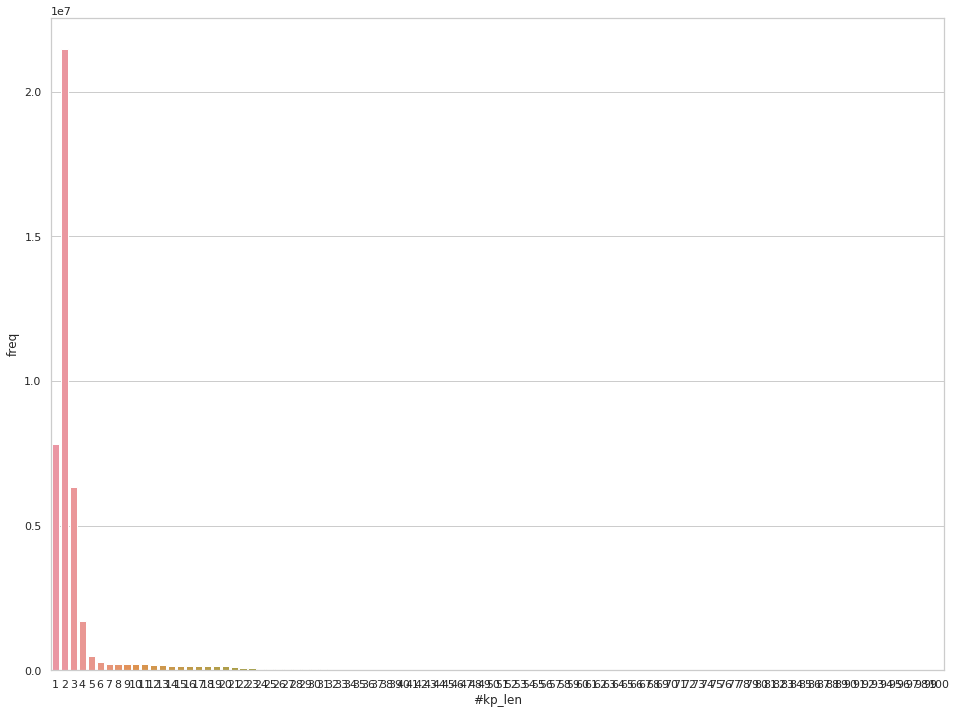

In [18]:
fig, ax = plt.subplots(figsize=(16, 12))
sns.set(style="whitegrid")
kp_lens = sorted([(kp_len, freq) for kp_len, freq in kp_len_counter.items()], key=lambda k:k[0])

accum_kp_count = 0
total_kp_count = sum(freq for _, freq in kp_lens)
for kp_len, freq in kp_lens:
    accum_kp_count += freq
    print('#kp_len=%d, freq=%d, accum/total=%.2f%%' % (kp_len, freq, accum_kp_count / total_kp_count * 100))
    
print(len(kp_lens))
kp_lens_df = pd.DataFrame(kp_lens, columns=['#kp_len', 'freq'])
ax = sns.barplot(x="#kp_len", y="freq", data=kp_lens_df)
